# Los Altos and Mountain View Stop Rates
Let's look at stop rates in Los Altos and Mountain View for the first 3 quarters of 2023. We'll try to see if there are differences in the rates at which different races are stopped.

In [2]:
import pandas as pd
import os
import glob
import sys

In [3]:
sys.path.append("../../code")
import loaders.losaltos as lla
import loaders.mountainview as lmv
import analysis.populations as pop

Use the handy loaders to get the data from just 2023.

In [4]:
mv_dir = "../../data/clean_data/"
mv_df =  lmv.load_ripa_data(glob.glob(os.path.join(mv_dir, "MVPD_RIPA_*2023*.csv")), dir=mv_dir, verbose=True)

Records: 1079 Stop IDs: [400122, 509895]  Date Range: [2022-12-20 23:55:00, 2023-04-01 05:00:00]
Records: 1075 Stop IDs: [510697, 626027]  Date Range: [2023-03-16 19:10:00, 2023-07-01 06:14:00]
Records: 1150 Stop IDs: [626091, 754662]  Date Range: [2022-11-18 17:50:00, 2023-10-08 01:55:00]


In [5]:
la_dir = "../../data/clean_data/"
la_df =  lla.load_ripa_data(glob.glob(os.path.join(mv_dir, "LAPD_RIPA_*2023*.csv")), dir=mv_dir, verbose=True)

Records: 880 Stop IDs: [5743, 6616]  Date Range: [2023-01-01 22:30:00, 2023-06-30 22:42:00]


To simplify things, we're just going to look at the races with the most stops. Notably this leaves out people who are listed as two or more races; that is a good subject for future work.

In [15]:
comparison_races =["White", "Hispanic/Latino(a)", "Black/African American", "Asian", "Middle Eastern or South Asian"]

The dataframes contain one record for each stop. We'll need to count them up by race. For now, we'll count all of them, regardless of the type of stop or reason.

In [16]:
mv_stops_by_race = mv_df.query("race in @comparison_races")["race"].value_counts().rename("Mountain View")

In [17]:
la_stops_by_race = la_df.query("race in @comparison_races")["race"].value_counts().rename("Los Altos")

In [21]:
stops2023 = pd.concat([mv_stops_by_race[comparison_races], la_stops_by_race[comparison_races]], axis=1)

In [22]:
stops2023

,Mountain View,Los Altos
race,,
White,690,344
Hispanic/Latino(a),1330,236
Black/African American,197,35
Asian,434,132
Middle Eastern or South Asian,365,97


[Text(0, 0, 'White'),
 Text(1, 0, 'Hispanic/Latino(a)'),
 Text(2, 0, 'Black/African American'),
 Text(3, 0, 'Asian'),
 Text(4, 0, 'Middle Eastern or South Asian')]

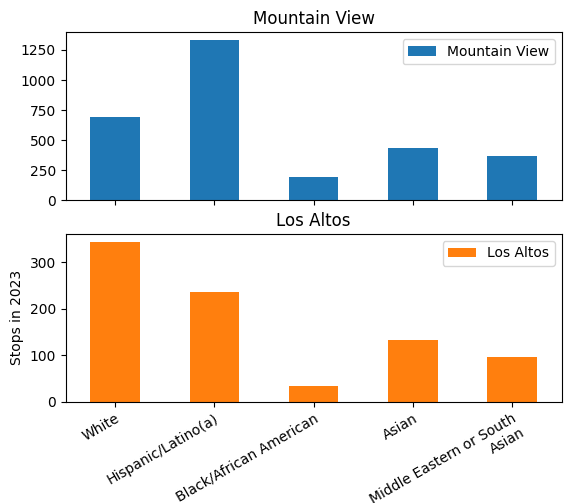

In [25]:
axs = stops2023.plot.bar(subplots=True)
axs[-1].set_ylabel("Stops in 2023")
axs[-1].set_xlabel("")
axs[-1].set_xticklabels(comparison_races, ha="right", wrap=True, rotation=30)

As we might expect, there are more stops overall in Mountain View than Los Altos; it's a bigger town. And the races with the most stops are probably also the races with the most population. In order to look at stop rates on a per-capita basis, we need to know what that population is. As a first cut, we'll use the resident population of each town, by race.

In [40]:
stop_rates2023 = pd.concat([(stops2023["Mountain View"]/pop.get_population("Mountain View")).rename("Mountain View"),
                            (stops2023["Los Altos"]/pop.get_population("Los Altos")).rename("Los Altos")],
                            axis=1) * 1000

[Text(0, 0, 'White'),
 Text(1, 0, 'Hispanic/Latino(a)'),
 Text(2, 0, 'Black/African American'),
 Text(3, 0, 'Asian'),
 Text(4, 0, 'Middle Eastern or South Asian')]

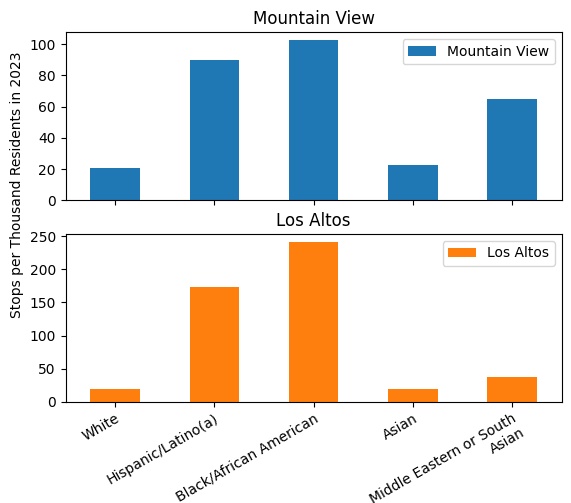

In [41]:
axs = stop_rates2023.loc[comparison_races].plot.bar(subplots=True)
# axs[-1].set_ylabel("Stops per capita")
# axs.set_title("Stops Per Capita, 2023")
axs[-1].set_ylabel("Stops per Thousand Residents in 2023", ha="left")
axs[-1].set_xlabel("")
axs[-1].set_xticklabels(comparison_races, ha="right", wrap=True, rotation=30)

Two things stick out in this graph. First, we see that Hispanics and Blacks are far more likely to be stopped than Whites or Asians. Second, we see that overall, the Los Altos police make many more stops per capita than the Mountain View police.

One criticism of this analysis could be that using the resident population to find per-capita rates isn't the right thing to do. After all, many people come into Los Altos and Mountain View during the day to work, even if they live elsewhere. Perhaps the apparent differences in the chart above are because we aren't using the appropriate population numbers.

One way to address that question would be to look at the ratio of equipment violations to moving violations. The story would be like this: most moving violations, for things like speeding or illegal turns, are evident to officers from far away, before they know the race of the driver. On the other hand, equipment violations are much more likely to be "pretext stops." Pretext stops are when an officer pulls someone over for one reason (like an expired registration) but actually they suspect the driver of some other criminality. If there is racial bias in the pretext stops, we would see a higher ratio of equipment violations to moving violations for people of color.

In [42]:
stop_ratios_2023 = pd.concat([
        (mv_df.query("race in @comparison_races and Tr_ID == 'Equipment'")["race"].value_counts()/
        mv_df.query("race in @comparison_races and Tr_ID == 'Moving'")["race"].value_counts()).rename("Mountain View"),
        (la_df.query("race in @comparison_races and reasonForStopDetail == 'Equipment Violation'")["race"].value_counts()/
         la_df.query("race in @comparison_races and reasonForStopDetail == 'Moving Violation'")["race"].value_counts()).rename("Los Altos")
], axis=1)


[Text(0, 0, 'White'),
 Text(1, 0, 'Hispanic/Latino(a)'),
 Text(2, 0, 'Black/African American'),
 Text(3, 0, 'Asian'),
 Text(4, 0, 'Middle Eastern or South Asian')]

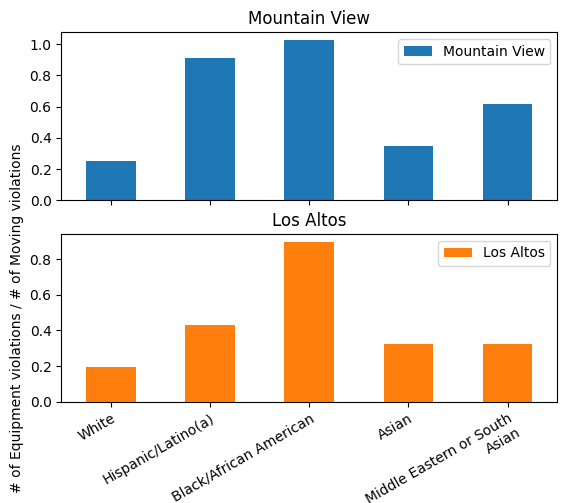

In [43]:
axs = stop_ratios_2023.plot.bar(subplots=True)
axs[-1].set_ylabel("# of Equipment violations / # of Moving violations")
axs[-1].set_xlabel("")
axs[-1].set_xticklabels(comparison_races, ha="right", wrap=True, rotation=30)
#ax.set_title("Ratio of Equipment violations to Moving, 2023")

In both MV and LA, the ratio is substantially higher for Hispanic and Black folks. In Los Altos, Asian and South Asian ratios are just slightly higher than White ratios; in MV the South Asian ratio is definitely higher.

This data seems to confirm the experience of most people of color on the Peninsula: they are much more likely to be stopped, and for flimsier reasons, than White people are.